In [1]:
#!pip install langdetect
#!pip install scattertext
#!pip install spacy
#!pip install gensim
#!pip install pyLDAvis

In [29]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
sw = stopwords.words("english")

## Load Data

In [3]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


## Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: separate sentences, remove URLs, non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [4]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [5]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [6]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [7]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

# spot cleanup experience
df.required_experience = np.where(df.required_experience == 'not applicable', 'missing', df.required_experience)

In [8]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-8-1762eb734427>:12: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
<ipython-input-8-1762eb734427>:13: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs


In [9]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [10]:
# drop salary range variable 
del df['salary_range']

## EDA

In [11]:
df.fraudulent = pd.to_numeric(df.fraudulent)

__Data Distributions__    
If lots of values, plot both head and tail to get sense of range

In [80]:
def hist_plt(col, tail = False):
    
    if tail:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        num = 10
    else:
        f, ax1 = plt.subplots()
        num = 1000
        
    head = df[col].value_counts().head(num)
    ax1.bar(head.index, head)
    ax1.set_xticklabels(labels = head.index, rotation=90)
    
    if tail:
        tail = df[col].value_counts().tail(10)
        ax2.bar(tail.index, tail)
        ax2.set_xticklabels(labels = tail.index, rotation=90)


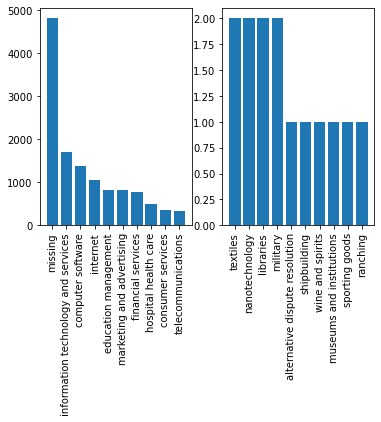

In [76]:
hist_plt('industry', tail = True)

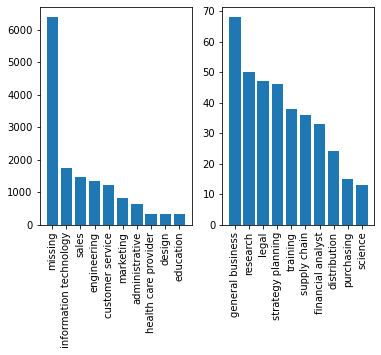

In [77]:
hist_plt('function', tail = True)

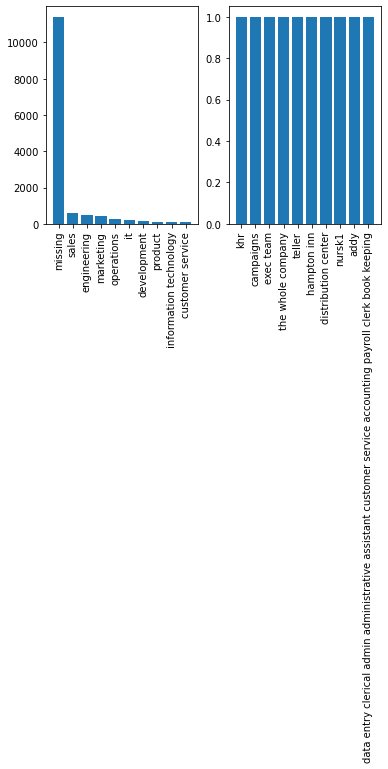

In [78]:
hist_plt('department', tail = True)

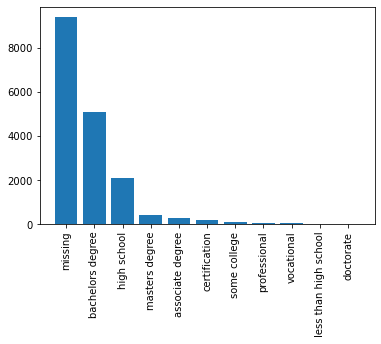

In [83]:
hist_plt('education_bin')

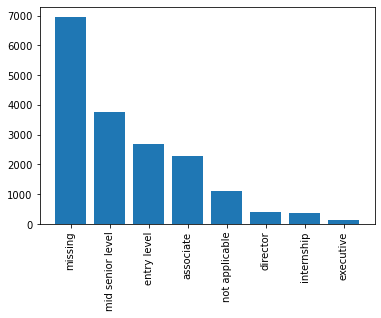

In [82]:
hist_plt('required_experience')

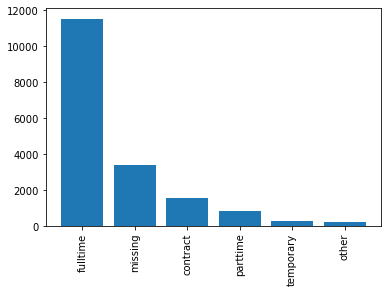

In [84]:
hist_plt('employment_type')

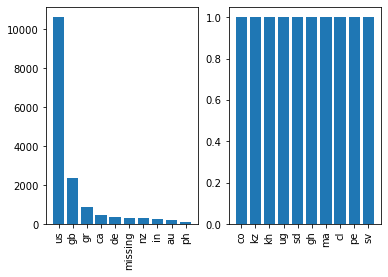

In [86]:
hist_plt('country', tail = True)

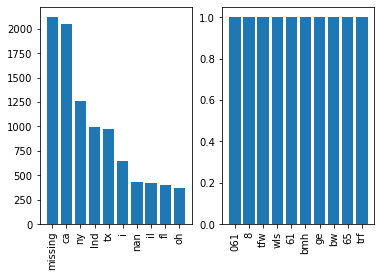

In [87]:
hist_plt('state', tail = True)

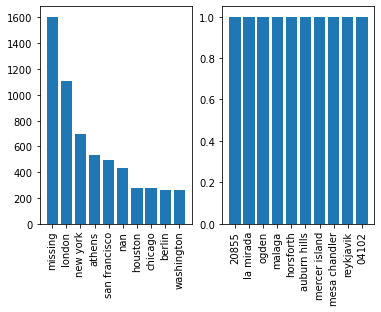

In [88]:
hist_plt('city', tail = True)

__Bar Plots of Metadata Frequency in Fraudulent Posts__

In [12]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

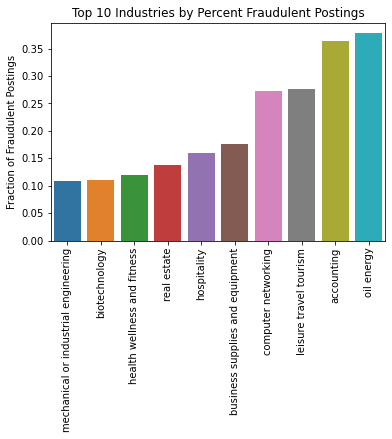

In [13]:
bar_plt('industry', 'Industries')

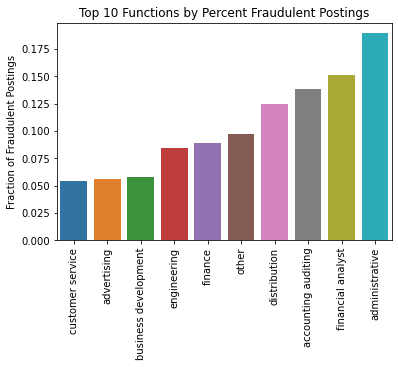

In [14]:
bar_plt('function', 'Functions')

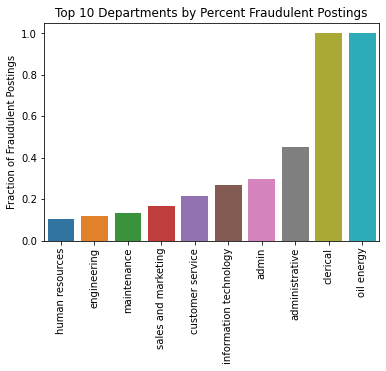

In [15]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

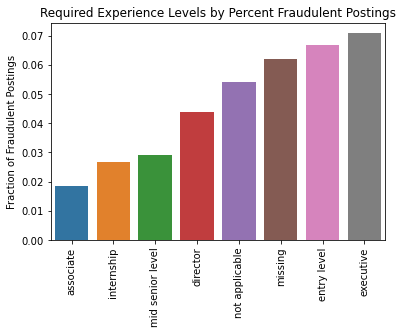

In [16]:
bar_plt('required_experience', 'Required Experience Levels')

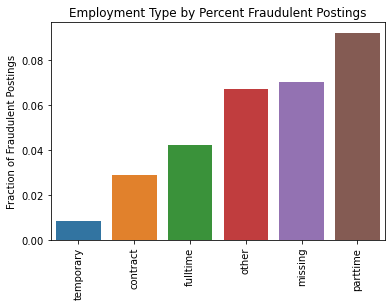

In [17]:
bar_plt('employment_type', 'Employment Type')

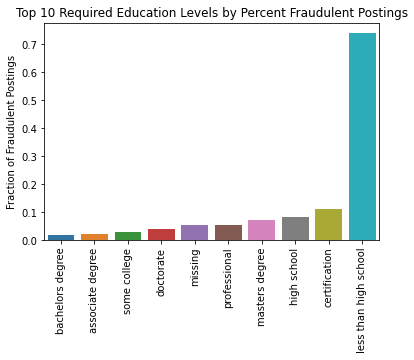

In [18]:
bar_plt('education_bin', 'Required Education Levels')

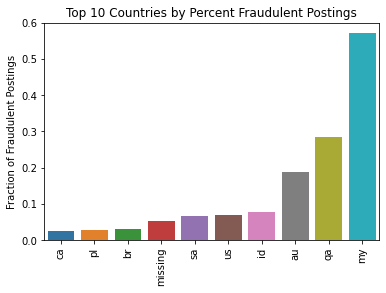

In [19]:
bar_plt('country', 'Countries')

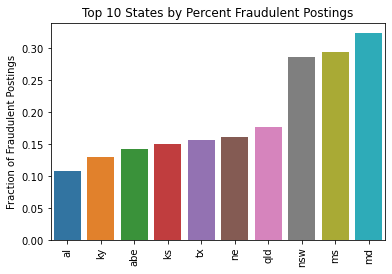

In [20]:
bar_plt('state', 'States')

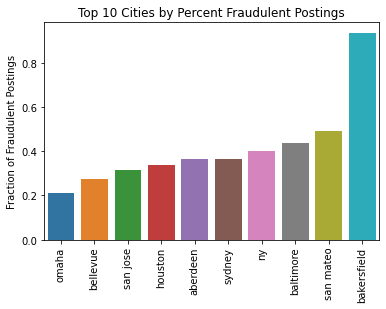

In [21]:
bar_plt('city', 'Cities')

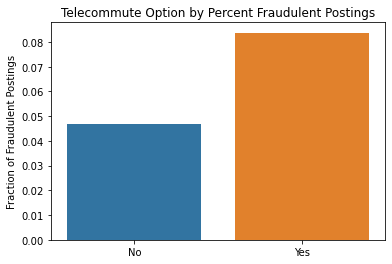

In [22]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

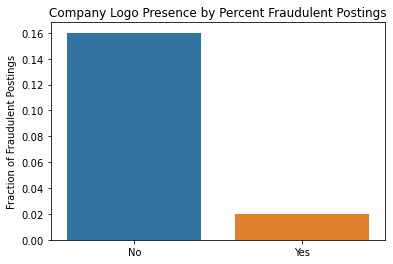

In [23]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

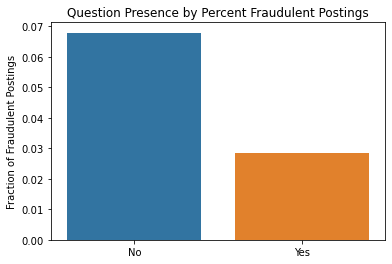

In [24]:
bar_plt('has_questions', 'Question Presence', boolean = True)

__Visualize Common Words in Fake vs Real Postings using Scattertext__   
Tokenize and remove stop words. Don't bother with lemmatization for exploratory analysis + interferes with ability to see examples using scattertext interactive html

In [12]:
nlp = spacy.load('en')

In [25]:
# run in terminal (with admina priviledges): 'py -m spacy download en'
#nltk.download('stopwords')

In [13]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [27]:
def scattertext_visualize(col):
    
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    open('./scattertext_' + col + '.html', 'w').write(html)

In [28]:
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for c in nlp_columns:
    scattertext_visualize(c)

## Topic Modeling
Sections of code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

- Combine text fields into single string
- Tokenize, remove stop words, lemmatize based on POS 
- Build term frequency corpus
- Build LDA Model
    - Tune based on topic coherence. Specificall C_V coherence
    
Topic coherence: Degree of semantic similarity between high scoring words in the topic    
Modern alternative to perplexity: how suprised a model is by new data (normalized log likelihood of held out test set)    
CV_coherence: "C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity"       
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0   
  
Parameters:
- Number of Topics
- Alpha
- Eta
    - Selecting alpha and eta with built in auto method which learns an asymetric prior from the data
     
From https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/: (assuming symmetric data)
"alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words"

In [14]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = (df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits + ' ' +
              df.industry + ' ' + df.function)
# don't include location (country, state, city) here because will be excluded in lemmatization (proper noun)
# use as metadata

In [ ]:
# function from
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [334]:
# tokenize
df.text = df.text.apply(lambda row: row.split(' '))
# remove stop words
df.text = df.text.apply(lambda row: [w for w in row if w not in sw])

# convert into list 
text = df.text.values.tolist()

# lemmatize and remove proper nouns 
# ex removing company names. Not important for topic modeling. 
text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [335]:
# save text string (10 minutes to run tokenization through lemmatization process)
with open('textlst.pkl', 'wb') as f:
    pickle.dump(text, f)

In [15]:
with open('textlst.pkl', 'rb') as f:
    text = pickle.load(f)

In [16]:
# term document frequency corpus for LDA
corpus_dict = corpora.Dictionary(text)
corpus = [corpus_dict.doc2bow(t) for t in text]

In [103]:
#[[(corpus_dict[id], freq) for id, freq in cp] for cp in corpus[:2]]  - human readable format

In [337]:
# tune LDA model based on topic coherence values (maximize)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=corpus_dict,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta = 'auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [338]:
model_list, coherence_values = compute_coherence_values(dictionary=corpus_dict, corpus=corpus, texts=text, 
                                                        start=2, limit=20, step=1)
# 2.5 hours to run

2


3


4


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [347]:
np.argmax(coherence_values) # started at 2, this is position 12, so 15 topics

13

Text(0, 0.5, 'Coherence score')

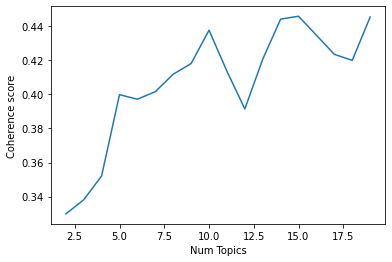

In [348]:
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# todo: change xticks to integers

In [341]:
with open('model_list.pkl', 'wb') as f:
    pickle.dump(model_list, f)
    
with open('coherence_values.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)

In [17]:
with open('model_list.pkl', 'rb') as f:
    model_list = pickle.load(f)
    
with open('coherence_values.pkl', 'rb') as f:
    coherence_values = pickle.load(f)

In [18]:
lda_model_best = model_list[np.argmax(coherence_values)]

In [343]:
# visualize topics - still don't look separate, even if they are coherent. investigate other ways to tune. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_best, corpus, corpus_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.102211 -0.177102       1        1  20.299320
4     -0.121517 -0.045074       2        1  17.053221
3     -0.112043  0.132734       3        1  13.363677
6     -0.126769 -0.085569       4        1   9.146260
12    -0.096027 -0.012587       5        1   8.468487
1      0.013092 -0.151597       6        1   5.318647
2     -0.067567  0.061262       7        1   4.000076
14    -0.040578  0.062419       8        1   3.906936
9     -0.057174 -0.125787       9        1   3.770564
11     0.035514  0.273102      10        1   3.532917
10     0.044698  0.176734      11        1   3.117130
7      0.037822  0.079615      12        1   2.993380
13     0.086896 -0.048172      13        1   2.699553
8      0.015559 -0.069321      14        1   2.123432
5      0.490304 -0.070657      15        1   0.206391, topic_info=              Term          Freq         Total Category  logprob  loglift
195       customer  39029.000000  39029.000000  Default  30.0000  30.0000
616           sale  22879.000000  22879.000000  Default  29.0000  29.0000
319        service  37771.000000  37771.000000  Default  28.0000  28.0000
718            job  16357.000000  16357.000000  Default  27.0000  27.0000
15        business  24185.000000  24185.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
8504        broker      0.044762      1.395623  Topic15 -12.0891   2.7434
36640      pay401k      0.044657      1.395519  Topic15 -12.0915   2.7411
3463   traditional      0.044739      1.399924  Topic15 -12.0897   2.7398
5269        seller      0.044602      1.395733  Topic15 -12.0927   2.7397
3458      retailer      0.044901      1.409529  Topic15 -12.0860   2.7366

[1038 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
152       1  0.023922  ability
152       2  0.098406  ability
152       3  0.415701  ability
152       4  0.122522  ability
152       5  0.008200  ability
...     ...       ...      ...
660      10  0.004338     year
660      11  0.035912     year
660      12  0.067196     year
660      13  0.048252     year
660      14  0.017016     year

[2464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 7, 13, 2, 3, 15, 10, 12, 11, 8, 14, 9, 6])

In [19]:
# reconstruct dataframe with metadata columns with topic probabilities 
topicdf = pd.DataFrame()
for i in range(0, np.argmax(coherence_values)+2):
    topicdf['topic' + str(i)] = 0
    
for i, row in enumerate(lda_model_best[corpus]):
    s = pd.Series(dtype = float)
    
    for j in row[0]:
        s['topic' + str(j[0])] = j[1] 
    topicdf = topicdf.append(s, ignore_index = True)

In [20]:
# merge
df = df.reset_index(drop = True)
df = pd.merge(df, topicdf, how = 'left', left_index = True, right_index = True)
# replace missings with 0s 
topic_cols = [c for c in df.columns if c.startswith('topic')]
for c in topic_cols:
    df[c] = np.where(df[c].isnull(), 0, df[c])

In [21]:
# save final dataframe ready for classification 
with open('finaldf.pkl', 'wb') as f:
    pickle.dump(df, f)

In [505]:
with open('finaldf.pkl', 'rb') as f:
    df = pickle.load(f)

## Classification

### Dummy Variables

In [22]:
for c in ['employment_type', 'required_experience', 'education_bin', 'country']:
    
    # many values for country, only create dummy if more than 100 job postings in that country
    if c == 'country':
        cnts = df.country.value_counts()
        cnts = cnts[cnts > 100]   
        df.country = np.where(df.country.isin(cnts.index), df.country, 'other')
    
    # create dummies 
    prefix = c
    dum = pd.get_dummies(df[c], prefix = c)
    df = df.join(dum)
    
# remove columns not needed for regression
df = df.drop(columns = ['employment_type', 'required_experience','required_education', 'education_bin', 'country', 'location',
                       'title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 
                        'industry', 'function', 'state', 'city', 'language', 'fraudulent_words', 'job_id', 'text'])

# remove one level from dummies to prevent collinearity
df = df.drop(columns = ['employment_type_missing', 'required_experience_missing', 'education_bin_missing', 'country_missing'])

### SMOTE: class imbalance
Would also like to explore weighting within the regression (ie LogisticRegression(class_weight = 'balanced')), but cannot easily do grid search for parameters with weighting - no package. Thus using SMOTE instead for MVP version

In [25]:
# code adapted from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

# X and Y data frames
X = df.loc[:, df.columns != 'fraudulent']
y = df.loc[:, df.columns == 'fraudulent']

# oversample setup
os = SMOTE(random_state=0)

# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# oversample training data 
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['fraudulent'])

# check the numbers of our data
print("Original number of fraudulent in data is", len(y_train[y_train.fraudulent == 1]))
print("length of oversampled data is ",len(os_data_X))
print("Number of real in oversampled data",len(os_data_y[os_data_y['fraudulent']==0]))
print("Number of fraudulent",len(os_data_y[os_data_y['fraudulent']==1]))
print("Proportion of real data in oversampled data is ",len(os_data_y[os_data_y['fraudulent']==0])/len(os_data_X))
print("Proportion of fraudulent data in oversampled data is ",len(os_data_y[os_data_y['fraudulent']==1])/len(os_data_X))

Original number of fraudulent in data is 687
length of oversampled data is  26956
Number of real in oversampled data 13478
Number of fraudulent 13478
Proportion of real data in oversampled data is  0.5
Proportion of fraudulent data in oversampled data is  0.5


### Set up Evaluation Functions

In [26]:
def lasso_predict(model):
    # predict
    predict = model.predict(X_test)

    # dataframe from true values
    true_df = pd.DataFrame(y_test.fraudulent.to_list())

    # predict probabilities rather than class
    prob = model.predict_proba(X_test) 
    prob_df = pd.DataFrame(prob)
    
    # get coefficients
    coef_dict = {}
    for coef, feat in zip(model.coef_[0,:], X_train.columns):
        coef_dict[feat] = coef
        
    # create dataframe from real and fake 
    predict_df = pd.DataFrame(predict)
    predict_df = pd.merge(true_df, predict_df, left_index = True, right_index = True)
    predict_df.columns = ['truth', 'predict']

    return predict, predict_df, true_df, prob_df, coef_dict

In [27]:
def metrics_print(predict_df, predict):
    # accuracy 
    print('Accuracy:', len(predict_df[predict_df.truth == predict_df.predict]) / len(predict_df))

    # true positive rate: predict fraudulent when actually fraudulent
    print('TPR:', len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 1)]) / len(predict_df[predict_df.truth == 1]))

    # true negative rate: predict real when actually real
    print('TNR:', len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 0)]) / len(predict_df[predict_df.truth == 0]))

    # false positive rate: predict fraudulent when actually real (companies upset)
    print('FPR:', len(predict_df[(predict_df.predict == 1) & (predict_df.truth == 0)]) / len(predict_df[predict_df.truth == 0]))

    # false negative rate: predict real when actually fake (job seekers upset)
    print('FNR:', len(predict_df[(predict_df.predict == 0) & (predict_df.truth == 1)]) / len(predict_df[predict_df.truth == 1]))
    
    # curve areas
    print('Area under ROC:', roc_auc_score(y_test.fraudulent.to_list(), predict))
    print("Area Under PR:", average_precision_score(y_test.fraudulent.to_list(), predict))

### Unregularized Logistic Regression

In [30]:
# balanced class weighting
lr = LogisticRegression(class_weight = 'balanced',  random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(X_train, y_train.fraudulent.to_list())

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [31]:
predict, predict_df, true_df, prob_df, coef_dict = lasso_predict(lr)
metrics_print(predict_df, predict)

Accuracy: 0.7922077922077922
TPR: 0.7687861271676301
TNR: 0.7934105075690115
FPR: 0.20658949243098843
FNR: 0.23121387283236994
Area under ROC: 0.7810983173683208
Area Under PR: 0.13463268675357715


In [32]:
# SMOTE 
lr_smote = LogisticRegression(random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(os_data_X, os_data_y.fraudulent.to_list())

In [33]:
predict, predict_df, true_df, prob_df, coef_dict = lasso_predict(lr_smote)
metrics_print(predict_df, predict)

Accuracy: 0.792772444946358
TPR: 0.7341040462427746
TNR: 0.7957850994360345
FPR: 0.20421490056396557
FNR: 0.2658959537572254
Area under ROC: 0.7649445728394046
Area Under PR: 0.12738114043834103


### Lasso CV
- No need to scale or normalize since all features are categorical or probabilities between 0 and 1    
- refit =  true means will refit with the best selected parameters after CV       
- Fit without intercept so can include all topic levels (which sum to 1). Still need to remove 1 level from the other dummies.       
- Increasing max_iter even to 5000 does not get rid of convergence warning

Iterations: repeat the following each with these 4 scoring metrics: roc auc, accuracy, precision, recall
1. Balanced weighting
    - class_weigthing = 'balanced'
    - penalty = 'l1' 
    - fit(X_train, y_train)
2. SMOTE 
    - penalty = 'l1'
    - fit(os_data_X, os_data_y)
3. SMOTE with elastic net penalty
    - SMOTE better than balanced weighting so keep with that
    - penalty = 'elasticnet'
    - l1_ratios = [0, .25, .5, .75, 1]
    - fit(os_data_X, os_data_y)
    
__Best: SMOTE with accuracy/recall (all same results) and l1 penalty__

In [36]:
def logistic_iteration(x, y, penalty, l1_ratios, weighting, filename):

    lrcv_roc = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'roc_auc', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_acc = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'accuracy', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_prec = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'precision', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_rec = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'recall', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    
    model_list = [lrcv_roc, lrcv_acc, lrcv_prec, lrcv_rec]
    
    # save model list
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(model_list, f)

In [37]:
# balanced weighting
logistic_iteration(X_train, y_train, 'l1', None, 'balanced', 'lasso_list_scoring')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

In [39]:
# SMOTE 
logistic_iteration(os_data_X, os_data_y, 'elasticnet', [0, 0.25, 0.5, 0.75, 1], None, 'lasso_list_scoring_smote')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\pr

In [46]:
# elastic net with smote
logistic_iteration(os_data_X, os_data_y, 'l1', None, None, 'lasso_list_scoring_smote_elasticnet') 

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\pr

In [432]:
#sorted(sklearn.metrics.SCORERS.keys()) scoring metrics. try roc_auc, average_precision, average roc

In [47]:
with open('lasso_list_scoring.pkl', 'rb') as f:
    model_list = pickle.load(f)
with open('lasso_list_scoring_smote.pkl', 'rb') as f:
    model_list_smote = pickle.load(f)
with open('lasso_list_scoring_smote_elasticnet.pkl', 'rb') as f:
    model_list_en = pickle.load(f)

In [48]:
for i in model_list_en:
    print(str(i))
    predict, predict_df, true_df, prob_df, coef_dict = lasso_predict(i)
    #print(coef_dict)
    metrics_print(predict_df, predict)
    
# not materially different from smote without elastic net

LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='roc_auc', solver='saga')
Accuracy: 0.7922077922077922
TPR: 0.7398843930635838
TNR: 0.7948946274859009
FPR: 0.20510537251409913
FNR: 0.26011560693641617
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601916
LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='accuracy', solver='saga')
Accuracy: 0.7907961603613778
TPR: 0.7341040462427746
TNR: 0.7937073315523895
FPR: 0.20629266844761057
FNR: 0.2658959537572254
Area under ROC: 0.763905688897582
Area Under PR: 0.12640698120213753
LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='precision', solver='saga')
Accuracy: 0.8537549407114624
TPR: 0.5260115606936416
TNR: 0.8705847432472544
FPR: 0.12941525675274562
FNR: 0.47398843930635837
Area under ROC: 0.6982981519704481

In [49]:
for i in model_list:
    print(str(i))
    predict, predict_df, true_df, prob_df, coef_dict = lasso_predict(i)
    #print(coef_dict)
    metrics_print(predict_df, predict)
    
# recall does the best at minimizing FNR (as is its purpose) and everything else is just slightly worse

LogisticRegressionCV(class_weight='balanced', cv=5, fit_intercept=False,
                     max_iter=1000, penalty='l1', random_state=1,
                     scoring='roc_auc', solver='saga')
Accuracy: 0.8289102202145681
TPR: 0.6127167630057804
TNR: 0.8400118729593351
FPR: 0.1599881270406649
FNR: 0.3872832369942196
Area under ROC: 0.7263643179825577
Area Under PR: 0.11961040453825249
LogisticRegressionCV(class_weight='balanced', cv=5, fit_intercept=False,
                     max_iter=1000, penalty='l1', random_state=1,
                     scoring='accuracy', solver='saga')
Accuracy: 0.9511575381140599
TPR: 0.0
TNR: 1.0
FPR: 0.0
FNR: 1.0
Area under ROC: 0.5
Area Under PR: 0.048842461885940144
LogisticRegressionCV(class_weight='balanced', cv=5, fit_intercept=False,
                     max_iter=1000, penalty='l1', random_state=1,
                     scoring='precision', solver='saga')
Accuracy: 0.7811970638057595
TPR: 0.7514450867052023
TNR: 0.7827248441674087
FPR: 0.217275155832591

In [43]:
for i in model_list_smote:
    print(str(i))
    predict, predict_df, true_df, prob_df, coef_dict = lasso_predict(i)
    #print(coef_dict)
    metrics_print(predict_df, predict)
    
# accuracy, recall all the same. Precision bad for TPR. accuracy/recall, roc very similar. 
# better than balanced weighting in general
# precision gives better accuracy but very bad TPR and FNR

LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='roc_auc', solver='saga')
Accuracy: 0.7922077922077922
TPR: 0.7398843930635838
TNR: 0.7948946274859009
FPR: 0.20510537251409913
FNR: 0.26011560693641617
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601916
LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='accuracy', solver='saga')
Accuracy: 0.7907961603613778
TPR: 0.7341040462427746
TNR: 0.7937073315523895
FPR: 0.20629266844761057
FNR: 0.2658959537572254
Area under ROC: 0.763905688897582
Area Under PR: 0.12640698120213753
LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='precision', solver='saga')
Accuracy: 0.8537549407114624
TPR: 0.5260115606936416
TNR: 0.8705847432472544
FPR: 0.12941525675274562
FNR: 0.47398843930635837
Area under ROC: 0.6982981519704481

__Select Best Model__

In [58]:
best_model = model_list_smote[0]
predict, predict_df, true_df, prob_df, coef_dict = lasso_predict(best_model)

In [59]:
coef_dict # not shrinking any coefficients to zero

{'telecommuting': -0.11085386664540414,
 'has_company_logo': -2.197136896548921,
 'has_questions': -0.06441331911687519,
 'topic0': 2.646591687649842,
 'topic1': -0.6909060339982203,
 'topic2': -0.07392391955423006,
 'topic3': 4.721300933782414,
 'topic4': 2.028549631537867,
 'topic5': 16.318320241528323,
 'topic6': 0.6185057258434992,
 'topic7': -0.13793393979972324,
 'topic8': -0.00431965909239315,
 'topic9': 3.918253381252397,
 'topic10': 0.3260801663087598,
 'topic11': 4.685298720447047,
 'topic12': 4.8505243641012346,
 'topic13': 1.1942642704981943,
 'topic14': 2.875316103835819,
 'employment_type_contract': -0.9677384764136101,
 'employment_type_fulltime': -0.23409023126803283,
 'employment_type_other': -0.8370931264801464,
 'employment_type_parttime': -0.523962578466856,
 'employment_type_temporary': -2.4491100114029076,
 'required_experience_associate': -1.0797698346931293,
 'required_experience_director': 0.017669307043123545,
 'required_experience_entry level': -0.84257046511

__Examine Different Thresholds__         
Changes are pretty small. I think keep with .5?

In [60]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6]
for i in threshold_list: 
    pred_thresh = prob_df.applymap(lambda x: 1 if x>i else 0)
    pred_thresh = pd.merge(pred_thresh, true_df, left_index = True, right_index = True)
    pred_thresh.columns = ['', 'predict', 'truth']
    
    print(i)
    metrics_print(pred_thresh, predict)

0.4
Accuracy: 0.7326369282891022
TPR: 0.7745664739884393
TNR: 0.7304838230929059
FPR: 0.2695161769070941
FNR: 0.2254335260115607
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601916
0.45
Accuracy: 0.7645398080180689
TPR: 0.7630057803468208
TNR: 0.7646185811813595
FPR: 0.23538141881864055
FNR: 0.23699421965317918
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601916
0.5
Accuracy: 0.7922077922077922
TPR: 0.7398843930635838
TNR: 0.7948946274859009
FPR: 0.20510537251409913
FNR: 0.26011560693641617
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601916
0.55
Accuracy: 0.8145115753811406
TPR: 0.6994219653179191
TNR: 0.8204214900563965
FPR: 0.17957850994360344
FNR: 0.30057803468208094
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601916
0.6
Accuracy: 0.8320158102766798
TPR: 0.6589595375722543
TNR: 0.8409023449094687
FPR: 0.1590976550905313
FNR: 0.34104046242774566
Area under ROC: 0.7673895102747423
Area Under PR: 0.12833985427601